In [1]:
import pickle
import sys
sys.path.extend(['C:\\git\\thesis_clean_v2'])
from OriKerasExtension.ThesisHelper import readCompleteMatFile, ExtractDataVer4
from experiments.pretrained_by_colors.color_utils import create_color_dictionary, get_color_from_stimuli
from keras.utils.np_utils import to_categorical
from scipy import stats


In [2]:
results = pickle.load(  open( r"C:\git\thesis_clean_v2\experiments\pretrained_by_colors\save_13_may_predict_color_all_subjects_except_one_and_fine_tune.p", "rb" ) )

In [3]:
len(results)
print results[0][0].keys()

['lstm_history', 'subject_name', 'mlp_history']


In [4]:



def downsample_data(data, number_of_original_samples, down_samples_param):
    new_number_of_time_stamps = number_of_original_samples / down_samples_param

    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval

def create_letter_test_data_color(gcd_res, down_samples_param, jitter=20):
    last_time_stamp = 800 + jitter
    fist_time_stamp = -200 +jitter
    color_dictionary = create_color_dictionary()
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)

    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 3], axis=0)]

    categorical_tags = to_categorical(
        get_color_from_stimuli(gcd_res['stimulus'][gcd_res['train_mode'] == 3], color_dictionary))
    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags

In [5]:
from keras.layers import Convolution2D, Activation, MaxPooling2D, Flatten, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.regularizers import l2



Using Theano backend.
Using gpu device 0: GeForce GT 740M (CNMeM is disabled, CuDNN not available)
C:\Anaconda\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [6]:
"""
define the neural network model:
"""
model_lstm = Sequential()

model_lstm.add(LSTM(input_dim=55, output_dim=20, return_sequences=True))
model_lstm.add(Dropout(0.01))
model_lstm.add(LSTM(input_dim=20, output_dim=20, return_sequences=False))
#     model_lstm.add(Dropout(0.01))
#     model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
model_lstm.add(Dense(5, W_regularizer=l2(0.006)))
model_lstm.add(Activation('softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop',)



In [7]:
import keras
"""
define the neural network model:
"""
model_mpl = Sequential()
model_mpl.add(keras.layers.core.Flatten(input_shape=(55, 25)))
model_mpl.add(Dense(input_dim=55 * 25, output_dim=20))
model_mpl.add(Dropout(0.3))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(output_dim=20, W_regularizer=l2(0.06)))
model_mpl.add(Activation('tanh'))
model_mpl.add(Dense(5))
model_mpl.add(Activation('softmax'))
model_mpl.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
print results[0]['lstm_history']['val_accuracies'][-1]
print results[0]['mlp_history']['val_accuracies'][-1]
print results[0]['mlp_history'].keys()
plt.plot(results[0]['lstm_history']['train_accuracies'])
plt.plot(results[0]['lstm_history']['val_accuracies'])
plt.show()

plt.plot(results[0]['lstm_history']['train_losses'])
plt.plot(results[0]['lstm_history']['val_losses'])
plt.show()


plt.plot(results[0]['mlp_history']['train_accuracies'])
plt.plot(results[0]['mlp_history']['val_accuracies'])
plt.show()

plt.plot(results[0]['mlp_history']['train_losses'])
plt.plot(results[0]['mlp_history']['val_losses'])
plt.show()


TypeError: list indices must be integers, not str

In [9]:
import numpy as np

data_set_locations = ["RSVP_Color83msVPicr.mat",
                      "RSVP_Color83msVPpia.mat",
                      "RSVP_Color83msVPfat.mat",
                      "RSVP_Color83msVPgcb.mat",
                      "RSVP_Color83msVPgcc.mat",
                      "RSVP_Color83msVPgcd.mat",
                      "RSVP_Color83msVPgcf.mat",
                      "RSVP_Color83msVPgcg.mat",
                      "RSVP_Color83msVPgch.mat",
                      "RSVP_Color83msVPiay.mat",
                      "RSVP_Color83msVPicn.mat"];


data_set_locations_116 = ["RSVP_Color116msVPicr.mat",
                      "RSVP_Color116msVPpia.mat",
                      "RSVP_Color116msVPfat.mat",
                      "RSVP_Color116msVPgcb.mat",
                      "RSVP_Color116msVPgcc.mat",
                      "RSVP_Color116msVPgcd.mat",
                      "RSVP_Color116msVPgcf.mat",
                      "RSVP_Color116msVPgcg.mat",
                      "RSVP_Color116msVPgch.mat",
                      "RSVP_Color116msVPiay.mat",
                      "RSVP_Color116msVPicn.mat"];

lstm_accuracy = []
mlp_accuracy = []

for i, subject_name in enumerate(data_set_locations_116):
    
    subject_data = next(x for x in results if x[0]['subject_name'] == subject_name)[0]
    print (subject_data['subject_name'])
    
    model_lstm.set_weights(subject_data['lstm_history']['weights'])
    model_mpl.set_weights(subject_data['mlp_history']['weights'])
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)
    jitter = 0
#     for jitter in range(-50,50,25):
    single_subject_test_data, single_subject_test_tags = create_letter_test_data_color(gcd_res, down_samples_param=8,jitter=jitter)
    
    lstm_eval_res = model_lstm.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
    mlp_eval_res = model_mpl.evaluate(stats.zscore(single_subject_test_data, axis=1),single_subject_test_tags, show_accuracy=True)
    print lstm_eval_res
    print mlp_eval_res
    lstm_accuracy.append([subject_name,lstm_eval_res[1]])
    mlp_accuracy.append([subject_name,mlp_eval_res[1]])
    


RSVP_Color116msVPicr.mat
(18600L, 200L, 55L)
5400/5400 [==============================] - 0s     
[0.46760481746108445, 0.86685185185185187]
[0.3040626412409323, 0.90407407407407403]
RSVP_Color116msVPpia.mat
(20700L, 200L, 55L)
7500/7500 [==============================] - 0s     
[0.1771348007361094, 0.94933333333333336]
[0.11483611811002095, 0.96413333333333329]
RSVP_Color116msVPfat.mat
(18600L, 200L, 55L)
5400/5400 [==============================] - 0s     
[0.23570608324474759, 0.93148148148148147]
[0.2255377471005475, 0.93074074074074076]
RSVP_Color116msVPgcb.mat
(19500L, 200L, 55L)
6300/6300 [==============================] - 0s     
[0.15363549932600959, 0.95698412698412694]
[0.10034808260107797, 0.96460317460317457]
RSVP_Color116msVPgcc.mat
(18300L, 200L, 55L)
5100/5100 [==============================] - 0s     
[0.23442604272973303, 0.93058823529411761]
[0.18771079960991355, 0.93941176470588239]
RSVP_Color116msVPgcd.mat
(21000L, 200L, 55L)
7800/7800 [===========================

In [10]:
print lstm_accuracy

[['RSVP_Color116msVPicr.mat', 0.86685185185185187], ['RSVP_Color116msVPpia.mat', 0.94933333333333336], ['RSVP_Color116msVPfat.mat', 0.93148148148148147], ['RSVP_Color116msVPgcb.mat', 0.95698412698412694], ['RSVP_Color116msVPgcc.mat', 0.93058823529411761], ['RSVP_Color116msVPgcd.mat', 0.85141025641025636], ['RSVP_Color116msVPgcf.mat', 0.78833333333333333], ['RSVP_Color116msVPgcg.mat', 0.61551282051282052], ['RSVP_Color116msVPgch.mat', 0.76097222222222227], ['RSVP_Color116msVPiay.mat', 0.69616666666666671], ['RSVP_Color116msVPicn.mat', 0.878]]


[  0.2   1.2   2.2   3.2   4.2   5.2   6.2   7.2   8.2   9.2  10.2  11.7]


C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


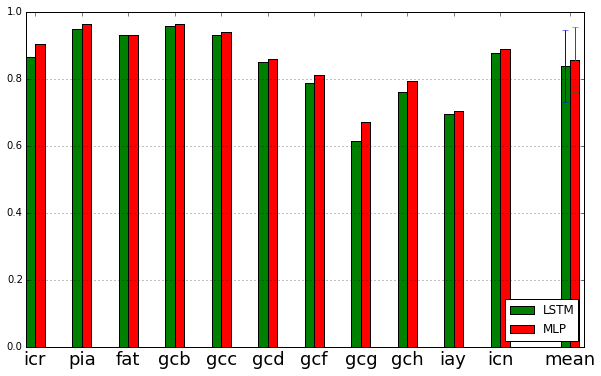

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ind = np.arange(len(lstm_accuracy))
width = 0.2
lstm_accuracies = [x[1]for x in lstm_accuracy]
mlp_accuracies =  [x[1]for x in mlp_accuracy]

aggregation_location = 11.5

rects1 = ax.bar(ind,lstm_accuracies,width,color='g')
rects2 = ax.bar(ind + width,mlp_accuracies,width,color='r')
mean_lstm = ax.bar([aggregation_location],[np.mean(lstm_accuracies)],width,color='g', yerr=[np.std(lstm_accuracies)])
mean_mlp = ax.bar([aggregation_location+ width],[np.mean(mlp_accuracies)],width,color='r',  yerr=[np.std(mlp_accuracies)])

ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy]+['mean'])
ind = np.asarray(list(ind) + list([aggregation_location])) +  width
print  ind
ax.set_xticks(ind  )

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 


ax.yaxis.grid()
# ax.set_xticks([13])
# ax.set_xticklabels()


ax.legend((rects1[0], rects2[0]), ('LSTM', 'MLP'), loc=4)

plt.show()

[x[1]for x in mlp_accuracy]+ [np.mean([x[1]for x in mlp_accuracy])]
[x[1]for x in lstm_accuracy]+ [np.mean([x[1]for x in lstm_accuracy])]

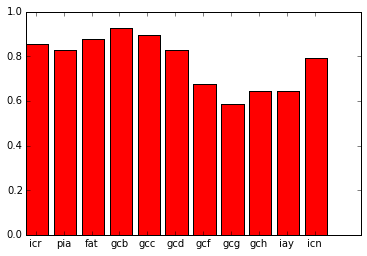

In [21]:
fig, ax = plt.subplots()
rects1 = ax.bar(ind,[x[1]for x in mlp_accuracy],color='r')
ax.set_xticks(ind + width)
ax.set_xticklabels([x[0][-7:-4] for x in lstm_accuracy])
plt.show()

In [14]:
# results.keys()
next(x for x in results if x[0]['subject_name'] == "RSVP_Color116msVPgcb.mat")

[{'lstm_history': {'train_accuracies': [0.22557575757575757,
    0.26865151515151514,
    0.32160606060606062,
    0.50275757575757574,
    0.66727272727272724,
    0.72959090909090907,
    0.76686363636363641,
    0.79045454545454541,
    0.80825757575757573,
    0.82245454545454544,
    0.83703030303030301,
    0.84843939393939394,
    0.85777272727272724,
    0.86621212121212121,
    0.87181818181818183,
    0.87718181818181817,
    0.88066666666666671,
    0.88592424242424239,
    0.88986363636363641,
    0.89206060606060611],
   'train_losses': [1.6302292354468144,
    1.5881846080837827,
    1.5465426515232432,
    1.3045937766161833,
    0.97585655232631796,
    0.82720391023520268,
    0.73924021905841253,
    0.68020024533705281,
    0.63140793959299724,
    0.59175830612760605,
    0.55380335989865392,
    0.51947056215459653,
    0.49248187001546223,
    0.46976819987730545,
    0.45139434753764757,
    0.43582851322491961,
    0.42456563750180332,
    0.41225432812083851,
 